In [1]:
import numpy as np
import pandas as pd


In [2]:
def make_lags(df, cols, lags):
    return pd.concat([df[col].shift(lag).rename(f"{col}_L{lag}") for col in cols for lag in lags], axis=1)

In [3]:
df = pd.read_csv("../../../data/cleaned/bandarAbas_multi_var_wind_3hourly_cleaned.csv")
df = df.sort_values('datetime').reset_index(drop=True)
df['wind_speed'] = df['wind_speed'].astype(float)

In [4]:
LAGS = [1,2,3,23,24,25,48]
df = df.join(make_lags(df[['wind_speed']], ['wind_speed'], LAGS)).dropna()

In [5]:
df.head()

,datetime,temp,pressure,humidity,wind_direction,wind_speed,u,v,pressure_24h,wind_speed_L1,wind_speed_L2,wind_speed_L3,wind_speed_L23,wind_speed_L24,wind_speed_L25,wind_speed_L48
48,2023-03-27 00:00:00,23.000000,1010.1,59.0,60.0,4.0,-3.464102e+00,-2.000000,1011.454167,2.0,3.0,2.0,3.0,3.0,3.0,3.0
49,2023-03-27 03:00:00,23.400000,1010.8,67.0,50.0,2.0,-1.532089e+00,-1.285575,1011.400000,4.0,2.0,3.0,3.0,3.0,3.0,2.0
50,2023-03-27 06:00:00,26.700000,1012.3,57.0,130.0,4.0,-3.064178e+00,2.571150,1011.333333,2.0,4.0,2.0,5.0,3.0,3.0,4.0
51,2023-03-27 09:00:00,28.300001,1011.3,51.0,180.0,8.0,4.898587e-16,8.000000,1011.295833,4.0,2.0,4.0,6.0,5.0,3.0,3.0
52,2023-03-27 12:00:00,28.500000,1009.3,39.0,170.0,2.0,-3.472964e-01,1.969616,1011.304167,8.0,4.0,2.0,4.0,6.0,5.0,5.0


In [6]:
df.columns

Index(['datetime', 'temp', 'pressure', 'humidity', 'wind_direction',
       'wind_speed', 'u', 'v', 'pressure_24h', 'wind_speed_L1',
       'wind_speed_L2', 'wind_speed_L3', 'wind_speed_L23', 'wind_speed_L24',
       'wind_speed_L25', 'wind_speed_L48'],
      dtype='object')

In [7]:
df = df[['datetime', 'wind_speed', 'wind_speed_L1',
         'wind_speed_L2', 'wind_speed_L3', 'wind_speed_L23', 'wind_speed_L24',
       'wind_speed_L25', 'wind_speed_L48']]

In [8]:
# ensure the column is datetime *type*
df['date'] = pd.to_datetime(df['datetime'])   # or df['datetime'] if that's the name

# now extract hour
df['hour'] = df['date'].dt.hour
df['sin_h'] = np.sin(2 * np.pi * df['hour'] / 24)
df['cos_h'] = np.cos(2 * np.pi * df['hour'] / 24)

In [9]:
# 3. train/test split (last 720 rows locked)
train_end = len(df) - 720
test_df = df.iloc[train_end:].copy()

FEATS = [c for c in df.columns if '_L' in c] + ['sin_h', 'cos_h']


In [10]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error
import scipy.stats as stats # Used for parameter distributions

# --- Assumed Setup (from your original code) ---
# df = ... (your DataFrame)
# FEATS = [...] (your list of feature names)
# train_end = ... (the index where initial training ends)
# test_df = df.iloc[train_end:].copy()
# m = ... (your metrics module, e.g., sklearn.metrics)
# -------------------------------------------------

### 1. Define Parameter Distribution for RandomizedSearch
# We use distributions (like uniform, loguniform) instead of a fixed grid
# This is much faster and more efficient for periodic tuning.
param_dist = {
    'n_estimators': stats.randint(100, 1000),
    'max_depth': stats.randint(3, 10),
    'learning_rate': stats.loguniform(0.01, 0.3),
    'subsample': stats.uniform(0.6, 0.4), # [0.6, 1.0]
    'colsample_bytree': stats.uniform(0.6, 0.4), # [0.6, 1.0]
    'gamma': stats.uniform(0, 0.5),
    'reg_alpha': stats.loguniform(1e-3, 1.0),
    'reg_lambda': stats.loguniform(1e-3, 1.0),
}

### 2. Define Tuning and Retraining Settings
RETRAIN_INTERVAL = 168 # hours (weekly)
TUNING_WINDOW_HOURS = 2160 # Approx 3 months for tuning
N_ITER_RANDOM_SEARCH = 15 # Number of param combinations to try (faster)
N_SPLITS_INNER_CV = 3 # Fewer splits for speed during tuning


In [11]:

### 3. Rolling Retraining and Re-Tuning Loop
print("Starting rolling forecast with periodic re-tuning...")

preds = []
model = None # Start with no model
current_best_params = {} # Will be set on the first run

for t in range(train_end, len(df)):

    # Check if it's time to retrain and re-tune
    if (t - train_end) % RETRAIN_INTERVAL == 0:
        print(f"\n--- Retraining and Re-Tuning at index {t} ---")
        
        # --- A. RE-TUNING on a SLIDING window ---
        # We tune on a *recent* window to adapt to new conditions
        tune_start_idx = max(0, t - TUNING_WINDOW_HOURS)
        tune_window_df = df.iloc[tune_start_idx:t]
        
        X_tune = tune_window_df[FEATS].values
        y_tune = tune_window_df['wind_speed'].values
        
        print(f"Running RandomizedSearch on window {tune_start_idx} to {t}...")
        
        # Use TimeSeriesSplit for the inner cross-validation
        tscv_inner = TimeSeriesSplit(n_splits=N_SPLITS_INNER_CV)
        
        rs = RandomizedSearchCV(
            estimator=xgb.XGBRegressor(objective='reg:absoluteerror', 
                                       random_state=42, n_jobs=-1),
            param_distributions=param_dist,
            n_iter=N_ITER_RANDOM_SEARCH, # Much faster than grid search
            cv=tscv_inner,
            scoring='neg_mean_absolute_error',
            verbose=0, # Set to 1 or more for details
            n_jobs=-1
        )
        
        rs.fit(X_tune, y_tune)
        
        # Update the parameters to use for this week's model
        current_best_params = rs.best_params_
        print(f"New best parameters found: {current_best_params}")

        # --- B. RE-TRAINING on an EXPANDING window ---
        # We train the final model on all available history
        # using the *newly found* best parameters.
        train_window_df = df.iloc[:t] 
        X_train_window = train_window_df[FEATS].values
        y_train_window = train_window_df['wind_speed'].values
        
        print(f"Retraining model on window 0 to {t}...")
        model = xgb.XGBRegressor(objective='reg:absoluteerror', 
                                 random_state=42, n_jobs=-1, 
                                 **current_best_params) # Use the new params
        
        model.fit(X_train_window, y_train_window)
        print("Model retrained successfully.")

    # --- C. PREDICTION ---
    # This happens every hour, using the most recently trained model
    
    # Handle the very first prediction if model isn't trained yet
    if model is None:
        # This case should be handled, e.g., by training a default
        # model before the loop. For this structure, we'll
        # just predict 0 or NaN for simplicity until first retrain.
        print("Waiting for first retraining cycle...")
        preds.append(np.nan) # Or a default value
        continue

    x_next = df.iloc[t][FEATS].values.reshape(1,-1)
    preds.append(model.predict(x_next)[0])


Starting rolling forecast with periodic re-tuning...

--- Retraining and Re-Tuning at index 2152 ---
Running RandomizedSearch on window 0 to 2152...
New best parameters found: {'colsample_bytree': np.float64(0.7988523479829797), 'gamma': np.float64(0.02963606831439919), 'learning_rate': np.float64(0.014426748331707399), 'max_depth': 3, 'n_estimators': 893, 'reg_alpha': np.float64(0.0026016021840063104), 'reg_lambda': np.float64(0.07493626647044765), 'subsample': np.float64(0.6313936798980054)}
Retraining model on window 0 to 2152...
Model retrained successfully.

--- Retraining and Re-Tuning at index 2320 ---
Running RandomizedSearch on window 160 to 2320...
New best parameters found: {'colsample_bytree': np.float64(0.7964883878962583), 'gamma': np.float64(0.3858965015651478), 'learning_rate': np.float64(0.012704183540599195), 'max_depth': 4, 'n_estimators': 220, 'reg_alpha': np.float64(0.024258829665686196), 'reg_lambda': np.float64(0.8599056035265766), 'subsample': np.float64(0.80059

In [12]:
import sklearn.metrics as m

In [13]:

# --- 4. Evaluation ---
test_df['pred_xgb_dynamic'] = preds
# Drop any initial NaNs if we had them
test_df = test_df.dropna(subset=['pred_xgb_dynamic'])

print("\n--- Final Results ---")
print("XGB MAE with Dynamic Re-Tuning:", 
      m.mean_absolute_error(test_df['wind_speed'], test_df['pred_xgb_dynamic']))


--- Final Results ---
XGB MAE with Dynamic Re-Tuning: 0.8523558257354631


In [14]:
# Get feature importance
importance = pd.DataFrame({
    'feature': FEATS,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print(importance.head(5))

          feature  importance
8           cos_h    0.323009
0   wind_speed_L1    0.192455
7           sin_h    0.119705
6  wind_speed_L48    0.107533
3  wind_speed_L23    0.067715


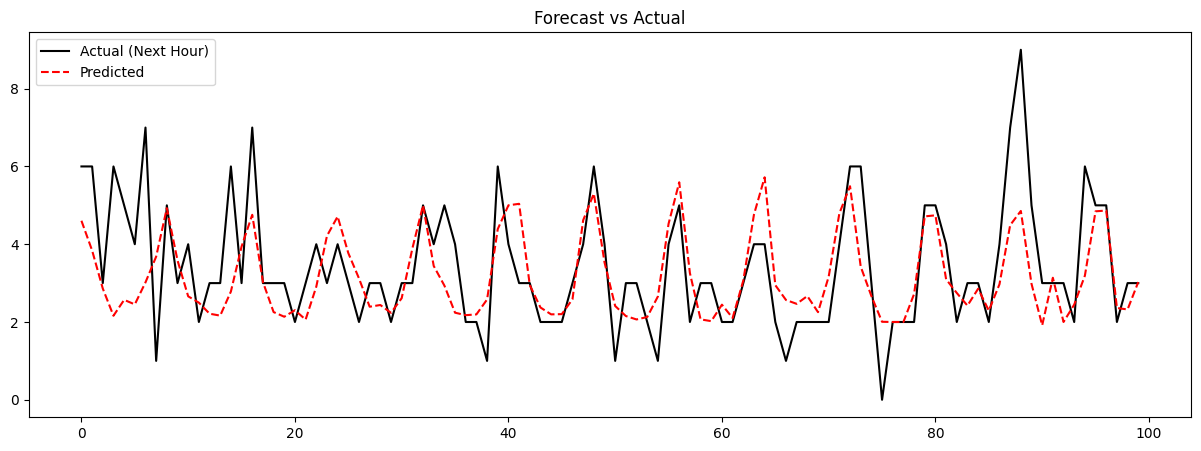

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))
plt.plot(y_tune[-100:], label='Actual (Next Hour)', color='black')
plt.plot(preds[-100:], label='Predicted', color='red', linestyle='--')
plt.legend()
plt.title("Forecast vs Actual")
plt.show()